# Two-Part Research Onboarding System Prototype

This notebook demonstrates the evolved onboarding agent with:
1. **Checklist Customization** - Research industry standards to customize requirements
2. **Answer Gathering** - Research specific answers to checklist items

## Important: Async/Await Support
This notebook uses async/await patterns for all asynchronous operations.

## 1. Setup and Imports

In [1]:
# Load environment variables from .env file
from dotenv import load_dotenv
import os

# Load your environment file
env_path = '/home/mohammed/Desktop/tech_projects/growbal/envs/1.env'
load_dotenv(env_path)

# Verify key APIs are loaded
apis_loaded = {
    'OpenAI': 'OPENAI_API_KEY' in os.environ,
    'Anthropic': 'ANTHROPIC_API_KEY' in os.environ,
    'Serper (Search)': 'SERPER_API_KEY' in os.environ,
    'LangSmith': 'LANGSMITH_API_KEY' in os.environ
}

print("🔑 API Keys Status:")
for api, loaded in apis_loaded.items():
    status = "✅ Loaded" if loaded else "❌ Not configured"
    print(f"  {api}: {status}")

# Disable LangSmith if no key is available
if not apis_loaded['LangSmith']:
    os.environ.pop('LANGCHAIN_TRACING', None)  # Remove if exists
    os.environ.pop('LANGCHAIN_TRACING_V2', None)  # Remove newer version flag
    print("\n⚠️ LangSmith tracing disabled (no API key found)")
else:
    os.environ['LANGCHAIN_TRACING_V2'] = 'true'
    print("\n✅ LangSmith tracing enabled")

🔑 API Keys Status:
  OpenAI: ✅ Loaded
  Anthropic: ✅ Loaded
  Serper (Search): ✅ Loaded
  LangSmith: ❌ Not configured

⚠️ LangSmith tracing disabled (no API key found)


In [2]:
# Import required libraries
import sys
import os
import asyncio
from datetime import datetime
import json
from typing import Dict, Any, List, Optional
import nest_asyncio
import logging
from IPython.display import clear_output

# Configure logging (silence noisy HTTP/OpenAI DEBUG logs)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
# Enforce levels explicitly in Jupyter
logging.getLogger().setLevel(logging.INFO)
for noisy in ["openai", "httpx", "httpcore", "urllib3", "langchain", "langgraph"]:
    lg = logging.getLogger(noisy)
    lg.setLevel(logging.WARNING)
    lg.propagate = False

# Verbose debugging option (uncomment to enable)
# logging.getLogger().setLevel(logging.DEBUG)
# for noisy in ["openai", "httpx", "httpcore", "urllib3", "langchain", "langgraph"]:
#     lg = logging.getLogger(noisy)
#     lg.setLevel(logging.DEBUG)
#     lg.propagate = True

# LangChain/LangGraph internals
os.environ['LANGCHAIN_VERBOSE'] = 'false'
os.environ['LANGSMITH_TRACING'] = 'false'
# Disable LangSmith tracing to avoid authentication errors
# os.environ['LANGCHAIN_TRACING'] = 'true'  # Uncomment only if you have LANGSMITH_API_KEY

# Apply nest_asyncio to allow nested event loops in Jupyter
nest_asyncio.apply()

# Add current directory to path
sys.path.insert(0, os.path.dirname(os.path.abspath('__file__')))

# Import our modules
from state_manager import (
    EvolvedOnboardingState, WorkflowDecision, initialize_state
)
from research_engine import TwoPartResearchOrchestrator
from workflow_agent import AdaptiveOnboardingAgent
from llm_wrapper import OnboardingLLM

# For Django integration
from django_interface import get_profile_by_id

print("✅ All imports successful!")
print("✅ Quiet logging enabled (OpenAI/httpx/httpcore silenced)")
print("✅ LangSmith tracing disabled (no API key)")

✅ All imports successful!
✅ Quiet logging enabled (OpenAI/httpx/httpcore silenced)
✅ LangSmith tracing disabled (no API key)


## 2. Initialize the Workflow Agent and Compile Graph

## 2. Initialize the Workflow Agent - Interactive vs Simulation Mode

### 🎮 Mode Selection
The agent now supports two modes:

1. **Interactive Mode** (`interactive_mode=True`):
   - Prompts for real user input during the workflow
   - You'll answer questions about your business
   - Provides a realistic onboarding experience
   - **Use this for production/real onboarding**

2. **Simulation Mode** (`interactive_mode=False`):
   - Uses automated responses
   - Good for testing and demonstrations
   - Runs without user intervention
   - **Use this for testing/development**

### 🐛 Fixed Issues:
1. **Removed hardcoded simulation** - Now actually prompts for user input when in interactive mode
2. **Fixed recursion limit** - Added proper status checking and max question limits
3. **Added confirmation prompts** - User can accept/reject research findings

Set `INTERACTIVE_MODE = True` below to enable real user interaction!

In [3]:
# Initialize the adaptive onboarding agent with mode selection

# Choose mode:
# - interactive_mode=True: Prompts for real user input (RECOMMENDED for actual use)
# - interactive_mode=False: Uses simulated responses (for testing/demo)

INTERACTIVE_MODE = True  # Set to False for simulation/testing

agent = AdaptiveOnboardingAgent(interactive_mode=INTERACTIVE_MODE)

print("✅ Agent initialized successfully!")
print(f"Graph nodes: {list(agent.graph.nodes.keys())}")
print(f"Graph compiled: {agent.graph is not None}")

# Print current state of the agent
print("\n📊 Current Agent State:")
print("=" * 50)
print(f"Mode: {'INTERACTIVE' if INTERACTIVE_MODE else 'SIMULATION'}")
print(f"LLM Wrapper: {type(agent.llm).__name__}")
print(f"Research Orchestrator: {type(agent.research_orchestrator).__name__}")
print(f"Graph Type: {type(agent.graph).__name__}")

# Check if the agent has an active state
if hasattr(agent, '_current_state'):
    print(f"Current State: {agent._current_state}")
else:
    print("Current State: No active state (agent ready to accept new sessions)")

# Note about state creation
print("\n💡 Note about State Creation:")
print("The agent doesn't maintain persistent state automatically.")
print("State is created per-session using initialize_state() function.")
print("Each workflow execution requires a new state initialization.")

if INTERACTIVE_MODE:
    print("\n⚠️ IMPORTANT: Interactive Mode is ON")
    print("You will be prompted to provide responses during the workflow.")
    print("Make sure you're ready to interact with the system!")

🎮 Interactive Mode: ENABLED - User input will be requested
✅ Agent initialized successfully!
Graph nodes: ['__start__', 'intake', 'research_decision', 'checklist_research', 'answer_research', 'evaluate_research', 'generate_question', 'process_response', 'update_checklist', 'request_confirmation', 'final_confirmation', 'save_results']
Graph compiled: True

📊 Current Agent State:
Mode: INTERACTIVE
LLM Wrapper: OnboardingLLM
Research Orchestrator: TwoPartResearchOrchestrator
Graph Type: CompiledStateGraph
Current State: No active state (agent ready to accept new sessions)

💡 Note about State Creation:
The agent doesn't maintain persistent state automatically.
State is created per-session using initialize_state() function.
Each workflow execution requires a new state initialization.

⚠️ IMPORTANT: Interactive Mode is ON
You will be prompted to provide responses during the workflow.
Make sure you're ready to interact with the system!


## 3. Visualize the Workflow Graph

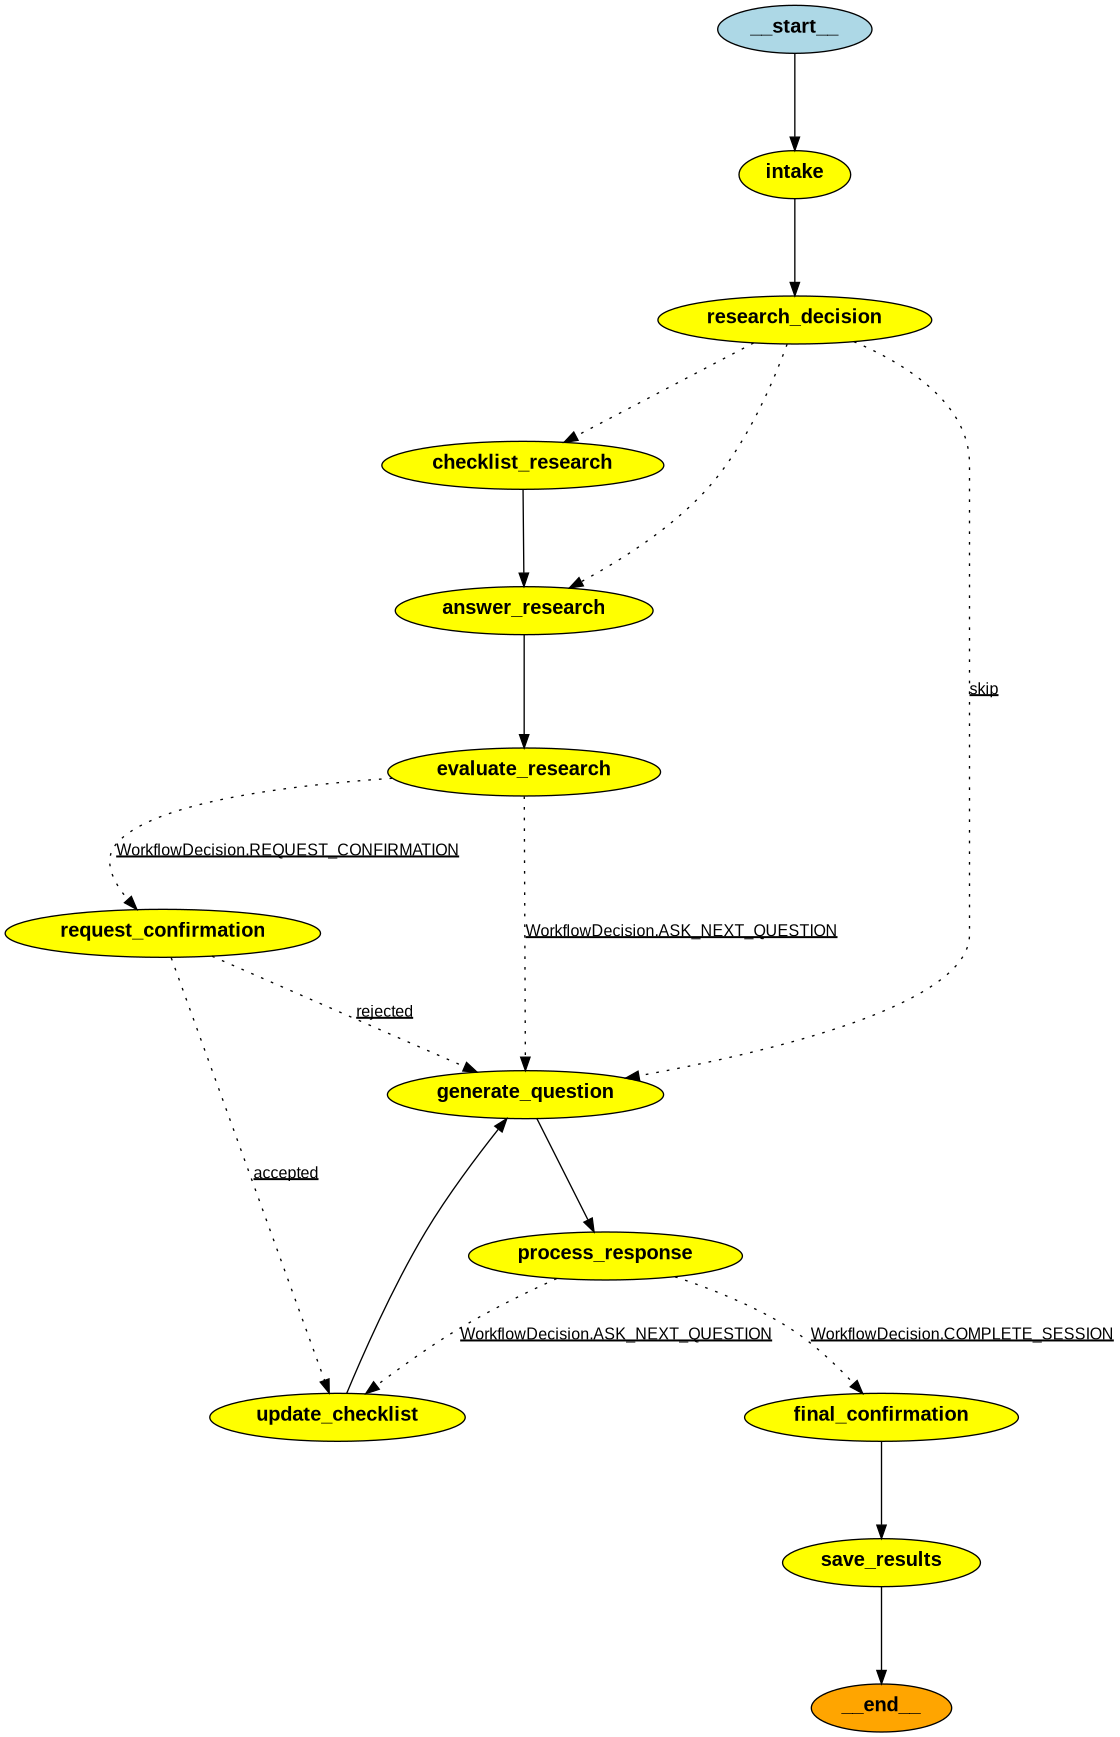

✅ Graph visualization generated!


In [4]:
# Try to visualize the graph with robust fallbacks
try:
    from IPython.display import Image, display

    graph = agent.graph.get_graph()

    graph_image = None
    errors = []

    # 1) Try local Graphviz rendering first (no internet required)
    try:
        graph_image = graph.draw_png()
    except Exception as e:
        errors.append(f"Graphviz draw_png failed: {e}")

    # 2) Try local (headless) Mermaid rendering via Pyppeteer
    if graph_image is None:
        MermaidDrawMethod = None
        try:
            from langgraph.graph.render import MermaidDrawMethod  # newer versions
        except Exception:
            try:
                from langgraph.graph.graph import MermaidDrawMethod  # older versions
            except Exception:
                MermaidDrawMethod = None
        if MermaidDrawMethod is not None:
            try:
                graph_image = graph.draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)
            except Exception as e:
                errors.append(f"Pyppeteer render failed: {e}")
        else:
            errors.append("MermaidDrawMethod not available in this langgraph version")

    # 3) Fallback to mermaid.ink with higher retries
    if graph_image is None:
        try:
            graph_image = graph.draw_mermaid_png(max_retries=5, retry_delay=2.0)
        except Exception as e:
            errors.append(f"Mermaid.ink render failed: {e}")

    # Display if we have an image
    if graph_image is not None:
        display(Image(graph_image))
        print("✅ Graph visualization generated!")
    else:
        raise RuntimeError("; ".join(errors))

except Exception as e:
    print(f"⚠️ Could not generate graph visualization: {e}")
    print("\nGraph structure (text representation):")
    print("----------------------------------------")
    # Try to print Mermaid source if available
    try:
        # Some versions expose a mermaid source helper; ignore if not available
        mermaid_src = graph.draw_mermaid() if 'graph' in locals() else agent.graph.get_graph().draw_mermaid()
        print(mermaid_src)
    except Exception:
        # Static textual fallback
        print("START → intake → research_decision")
        print("research_decision → {checklist_research, answer_research, generate_question}")
        print("checklist_research → answer_research")
        print("answer_research → evaluate_research")
        print("evaluate_research → {update_checklist, request_confirmation, generate_question}")
        print("request_confirmation → {update_checklist, generate_question}")
        print("update_checklist → generate_question")
        print("generate_question → process_response")
        print("process_response → {update_checklist, final_confirmation}")
        print("final_confirmation → save_results → END")

## 4. Pull Random Profile from Django Database

In [5]:
# # Function to get a random profile or create a mock one
# def get_test_profile() -> Dict[str, Any]:
#     """Get a test profile from Django or create a mock one"""
#     try:
#         # Try to get a random profile ID (you can change this)
#         import random
#         profile_id = random.randint(200, 480)
        
#         # Try to get profile from Django
#         while True:
#             profile_match = get_profile_by_id(profile_id)
#             if profile_match.profile_text:
#                 break
#             profile_id = random.randint(200, 480)
        
#         if profile_match:
#             return {
#                 "message": "Profile found",
#                 "id": profile_match.profile_id,
#                 "name": f"Provider {profile_match.profile_id}",
#                 "profile_text": profile_match.profile_text
#             }
#     except Exception as e:
#         print(f"Could not fetch from Django: {e}")
    
#     # Return mock profile if Django fetch fails
#     return {
#         "message": "No profile found"
#     }

# # Get test profile
# test_profile = get_test_profile()
# print("📋 Test Profile:")
# # Print profile text in a readable format
# if test_profile.get('profile_text'):
#     print("=== SERVICE PROVIDER PROFILE ===")
#     for line in test_profile['profile_text'].split('\n'):
#         # Skip the initial === SERVICE PROVIDER PROFILE === line since we're already printing it
#         if line.startswith('=== SERVICE PROVIDER PROFILE ==='):
#             continue
#         print(line)

In [6]:
# Import the new filtering functions
from django_interface import get_random_uae_profile, get_filtered_uae_profiles

# Enhanced function to get UAE profiles with better filtering
def get_test_uae_profile(min_description_length: int = 150, require_location: bool = False) -> Dict[str, Any]:
    """Get a test UAE profile with sufficient service descriptions"""
    try:
        # Try to get a random UAE profile with filtering
        profile_match = get_random_uae_profile(
            min_description_length=min_description_length,
            require_location=require_location
        )
        
        if profile_match:
            return {
                "message": "UAE Profile found",
                "id": profile_match.profile_id,
                "name": f"UAE Provider {profile_match.profile_id}",
                "profile_text": profile_match.profile_text
            }
        else:
            # Try with lower requirements
            profile_match = get_random_uae_profile(
                min_description_length=50,
                require_location=False
            )
            if profile_match:
                return {
                    "message": "UAE Profile found (lower requirements)",
                    "id": profile_match.profile_id,
                    "name": f"UAE Provider {profile_match.profile_id}",
                    "profile_text": profile_match.profile_text
                }
            
    except Exception as e:
        print(f"Could not fetch UAE profile from Django: {e}")
    
    # Return fallback message if no UAE profiles found
    return {
        "message": "No UAE profiles found with sufficient service descriptions"
    }

# Test the new filtering functionality
print("🔍 Testing UAE Profile Filtering...")

# Get all qualified UAE profiles (for statistics)
try:
    all_uae_profiles = get_filtered_uae_profiles(min_description_length=100, require_location=False)
    all_uae_with_location = get_filtered_uae_profiles(min_description_length=100, require_location=True)
    
    print(f"📊 UAE Profile Statistics:")
    print(f"   • Total UAE profiles with ≥100 chars service descriptions: {len(all_uae_profiles)}")
    print(f"   • UAE profiles with ≥100 chars descriptions + location: {len(all_uae_with_location)}")
    
except Exception as e:
    print(f"Error getting profile statistics: {e}")

# Get a test profile
test_uae_profile = get_test_uae_profile(min_description_length=150, require_location=False)
print(f"\n📋 Test UAE Profile: {test_uae_profile['message']}")

# Print profile text in a readable format if found
if test_uae_profile.get('profile_text'):
    print("\n=== UAE SERVICE PROVIDER PROFILE ===")
    for line in test_uae_profile['profile_text'].split('\n'):
        # Skip the initial === SERVICE PROVIDER PROFILE === line since we're already printing it
        if line.startswith('=== SERVICE PROVIDER PROFILE ==='):
            continue
        print(line)


🔍 Testing UAE Profile Filtering...
📊 UAE Profile Statistics:
   • Total UAE profiles with ≥100 chars service descriptions: 351
   • UAE profiles with ≥100 chars descriptions + location: 348

📋 Test UAE Profile: UAE Profile found

=== UAE SERVICE PROVIDER PROFILE ===
Company Name: ebs Chartered Accountants
Country: UAE
Email Addresses: info@ebs.ae
Website: https://www.ebs.ae
Office Locations: Dubai, UAE

=== SERVICES OFFERED ===

--- Service 1 ---
Title: Accounting and Auditing Services
Description: ebs is a leading accounting and auditing firm in Dubai, UAE offering comprehensive financial services including accounting, bookkeeping, auditing, VAT services, payroll management, CFO services, and temporary staffing solutions. They provide expert financial guidance and support to businesses across the UAE to help achieve their goals of growth, efficiency and profitability.
Tags: Accounting, Auditing, Bookkeeping, VAT Services, Payroll Services, CFO Services, Due Diligence, Financial Servic

## 5. Initialize State with Profile Data

In [ ]:
# Initialize state and run workflow directly with test UAE profile data
if test_uae_profile.get('profile_text'):
    print("🚀 Initializing state and running workflow...")
    print("=" * 50)
    
    # Create the initial state using the profile
    provider_profile = {
        'id': test_uae_profile.get('id'),
        'profile_text': test_uae_profile['profile_text']
    }
    
    # Initialize state (now includes built-in retry logic and research content capture)
    print("⏳ Initializing state with robust retry logic...")
    initial_state = initialize_state(provider_profile)
    
    print(f"✅ State initialized!")
    print(f"Workflow Status: {initial_state['workflow_status']}")
    print(f"Number of checklist items: {len(initial_state['checklist'])}")
    print(f"Research content captured: {len(initial_state['research_content'])} characters")
    
    # Display first few checklist items
    print(f"\n📋 Initial Checklist Items (first {len(initial_state['checklist'])}):")
    print("-" * 50)
    for i, item in enumerate(initial_state['checklist'], 1):
        print(f"{i}. [{item['key']}] {item['prompt']}")
        print(f"   Required: {item['required']} | Status: {item['status']}")
    
    # Display research content preview
    if initial_state['research_content']:
        print(f"\n🔍 Research Content Preview:")
        print("-" * 50)
        content_preview = initial_state['research_content'][:200] + "..." if len(initial_state['research_content']) > 200 else initial_state['research_content']
        print(f"{content_preview}")
    
    # Now run the workflow directly
    print(f"\n🎯 Starting Onboarding Workflow")
    print("=" * 60)
    print("⏳ Executing workflow... This may take a few moments as it performs web research.\n")
    
    try:
        # Run the workflow
        final_state = await agent.run(initial_state)
        
        print("\n✅ Workflow completed successfully!")
        print("=" * 60)
        
        # Display workflow summary
        print("\n📊 Workflow Summary:")
        print("-" * 40)
        print(f"Final Status: {final_state['workflow_status']}")
        print(f"Completion Rate: {final_state['completion_metrics']['completion_rate']:.1%}")
        print(f"Total Messages: {len(final_state['messages'])}")
        
        # Check research results
        if final_state.get('checklist_research_completed'):
            print(f"\n✅ Checklist Research: Completed")
            if final_state.get('checklist_modifications'):
                mods = final_state['checklist_modifications']
                print(f"  - Mandatory additions: {len(mods.get('mandatory_additions', []))}")
                print(f"  - Recommended additions: {len(mods.get('recommended_additions', []))}")
                print(f"  - Items to remove: {len(mods.get('items_to_remove', []))}")
        
        if final_state.get('answer_research_results'):
            print(f"\n✅ Answer Research: Completed")
            answers = final_state.get('research_answers', {})
            print(f"  - Answers found: {len(answers)}")
            if answers:
                print("  - Items with answers:")
                for key, data in list(answers.items())[:3]:  # Show first 3
                    print(f"    • {key}: {data.get('confidence', 0):.1%} confidence")
        
        # Display checklist completion status
        print("\n📋 Checklist Status:")
        print("-" * 40)
        status_counts = {}
        for item in final_state['checklist']:
            status = item['status']
            status_counts[status] = status_counts.get(status, 0) + 1
        
        for status, count in status_counts.items():
            print(f"  {status}: {count} items")
        
        # Show completed items
        completed_items = [item for item in final_state['checklist'] 
                          if item['status'] in ['VERIFIED', 'AUTO_FILLED']]
        
        if completed_items:
            print("\n✅ Completed Items (first 5):")
            for item in completed_items[:5]:
                print(f"  • [{item['key']}] {item['prompt']}")
                if item.get('value'):
                    print(f"    Value: {item['value']}")
                if item.get('confidence'):
                    print(f"    Confidence: {item['confidence']:.1%}")
        
        # Show recent messages
        if final_state['messages']:
            print("\n💬 Recent Conversation (last 3 messages):")
            print("-" * 40)
            for msg in final_state['messages'][-3:]:
                role = msg['role'].upper()
                content = msg['content'][:150] + "..." if len(msg['content']) > 150 else msg['content']
                print(f"[{role}]: {content}")
        
        # Show initial research content summary
        if final_state.get('research_content'):
            print(f"\n🔍 Initial Research Content: {len(final_state['research_content'])} characters captured during initialization")
        
    except Exception as e:
        print(f"\n❌ Error during workflow execution: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("❌ No profile data available. Please ensure a profile was loaded in the previous cell.")

🚀 Initializing state and running workflow...
⏳ Initializing state with robust retry logic...
✅ State initialized!
Workflow Status: initialized
Number of checklist items: 2
Research content captured: 3658 characters

📋 Initial Checklist Items (first 2):
--------------------------------------------------
1. [item_0] Please provide information.
   Required: True | Status: PENDING
2. [item_1] Please provide information.
   Required: True | Status: PENDING

🔍 Research Content Preview:
--------------------------------------------------
ebs | LinkedIn
ebs

المحاسبة

نبذة عنا

المواقع الجغرافية

موظفين في ebs

التحديثات

انضم الآن لعرض ما فاتك

الصفحات التابعة

صفحات مشابهة

قم بتسجيل الدخول لاستشكاف مَن تعرفه بالفعل في ebs

مرحبًا بع...

🎯 Starting Onboarding Workflow
⏳ Executing workflow... This may take a few moments as it performs web research.

⏱️ Starting workflow with 10-minute timeout protection
🚀 NODE: Intake Phase
  📝 Adding welcome message
🧠 NODE: Research Decision
  🔍 Decision: Pro